<a href="https://colab.research.google.com/github/llorenz29/Celeb-Variational-Autoencoder/blob/main/VAE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

We used this notebook for generating images of various celebrities: Barack Obama, Daniel Radcliffe, Leo Dicaprio, and more. Only a version with Lindsey Lohan is stored as output.

In [1]:
#imports

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as T

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn

Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
num_images = len(os.listdir("drive/MyDrive/final_project_data/lohan/")) #https://www.kaggle.com/datasets/kaustubhchaudhari/pubfig-dataset-256x256-jpg

ims = []

#Appending images to training data
for im_name in os.listdir("drive/MyDrive/final_project_data/lohan/"):
    s = (f"drive/MyDrive/final_project_data/lohan/{str(im_name)}")
    curr = torchvision.io.read_image(s)
    ims.append(curr)

ims = torch.stack(ims)

#normalize
ims = ims/255

Augment Data

In [4]:
"""
Experimented with augmentation, did not appear to aid our model significantly
"""

# transform_left = transforms.RandomRotation((0,25), fill = (1,1,1))
# transform_right = transforms.RandomRotation((-30,0), fill = (1,1,1))
# num_transforms = 2
# new_ims = []

# for i in range(0, num_transforms):
#   for im in ims:
#     if(i % 2 == 0):
#       new_ims.append(transform_left(im))
#     else:
#       new_ims.append(transform_right(im))

'\nExperimented with augmentation, did not appear to aid our model significantly\n'

In [5]:
# ims = torch.cat((ims, torch.stack(new_ims)))
# ims.shape

In [6]:
ims.shape

torch.Size([403, 3, 256, 256])

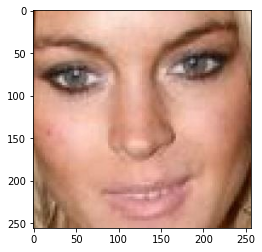

In [7]:
#plotting sample image
plt.imshow(transforms.ToPILImage()(ims[7]))

Encoder

In [8]:
class Encoder(nn.Module):
    """
    Encoder Class, compress a real image into a small embedding.

    Parameters:
    ----------
      Takes in a batch of ims of size 3x256x256

    Returns:
    --------
      mu: mean vector of size 128
      var: standard deviation vector of size 128
    """

    def __init__(self):
        super(Encoder, self).__init__()

        self.relu = nn.ReLU()

        self.conv_layer_1 =  nn.Conv2d(3,16,5,stride = 2,padding = 2)
        self.bn_1 = nn.BatchNorm2d(16)

        self.conv_layer_2 =  nn.Conv2d(16,32,5,stride = 2,padding = 2)
        self.bn_2 = nn.BatchNorm2d(32)

        self.conv_layer_3 =  nn.Conv2d(32,64,5,stride = 2,padding = 2)
        self.bn_3 = nn.BatchNorm2d(64)

        self.conv_layer_4 =  nn.Conv2d(64,128,5,stride = 2,padding = 2)
        self.bn_4 = nn.BatchNorm2d(128)

        self.conv_layer_5 =  nn.Conv2d(128,256,5,stride = 2,padding = 2)
        self.bn_5 = nn.BatchNorm2d(256)

        self.conv_layer_6 =  nn.Conv2d(256,512,5,stride = 2,padding = 2)
        self.bn_6 = nn.BatchNorm2d(512)

        self.flatten = nn.Flatten()

        #latent space layers
        self.mean = nn.Linear(8192,128) 
        self.log_var = nn.Linear(8192,128)

        # self.fc_layer_1 = nn.Linear(8192,128)

    def forward(self, x):

        x = self.conv_layer_1(x)
        x = self.bn_1(x)
        x = self.relu(x)

        x = self.conv_layer_2(x)
        x = self.bn_2(x)
        x = self.relu(x)

        x = self.conv_layer_3(x)
        x = self.bn_3(x)
        x = self.relu(x)

        x = self.conv_layer_4(x)
        x = self.bn_4(x)
        x = self.relu(x)

        x = self.conv_layer_5(x)
        x = self.bn_5(x)
        x = self.relu(x)

        x = self.conv_layer_6(x)
        x = self.bn_6(x)
        x = self.relu(x)

        x = self.flatten(x)

        mu = self.mean(x)
        var = self.log_var(x)

        # x =  self.fc_layer_1(x)

        return mu,var

Decoder

In [9]:
class Decoder(nn.Module):
    """
    Decoder Class, reconstruct the original image from the embedding.
    Uses transpose layers to expand input back to normal image size

    Parameters:
    ----------
      Takes in the reparameterized latent space vector of size 128

    Returns:
    --------
      returns an img of 3x256x256
    """

    def __init__(self,batch_size):
        super(Decoder, self).__init__()

        self.relu = nn.ReLU()

        self.fc_layer_1 = nn.Linear(128,8192)

        self.conv_layer_1 =  nn.ConvTranspose2d(512,256,4,stride = 2,padding =1)
        self.bn_1 = nn.BatchNorm2d(256)

        self.conv_layer_2 =  nn.ConvTranspose2d(256,128,4,stride = 2,padding =1)
        self.bn_2 = nn.BatchNorm2d(128)

        self.conv_layer_3 =  nn.ConvTranspose2d(128,64,4,stride = 2,padding =1)
        self.bn_3 = nn.BatchNorm2d(64)

        self.conv_layer_4 =  nn.ConvTranspose2d(64,32,4,stride = 2,padding =1)
        self.bn_4 = nn.BatchNorm2d(32)

        self.conv_layer_5 =  nn.ConvTranspose2d(32,16,4,stride = 2,padding =1)
        self.bn_5 = nn.BatchNorm2d(16)

        self.conv_layer_6 =  nn.ConvTranspose2d(16,3,4,stride = 2,padding =1)

        self.flatten = nn.Flatten()

        self.batch_size = batch_size

        self.last_1 = lambda x: x - torch.min(x)
        self.last_2 = lambda x: x / torch.max(x)


    def forward(self, x):

        x = self.fc_layer_1(x)

        x = self.relu(x)

        x = torch.reshape(x,(self.batch_size,512,4,4))

        x = self.conv_layer_1(x)
        x = self.bn_1(x)
        x = self.relu(x)

        x = self.conv_layer_2(x)
        x = self.bn_2(x)
        x = self.relu(x)

        x = self.conv_layer_3(x)
        x = self.bn_3(x)
        x = self.relu(x)

        x = self.conv_layer_4(x)
        x = self.bn_4(x)
        x = self.relu(x)

        x = self.conv_layer_5(x)
        x = self.bn_5(x)
        x = self.relu(x)

        x = self.conv_layer_6(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = torch.clamp(x,min=0,max=1)

        x = torch.reshape(x,(self.batch_size,3,256,256))

        return x


In [10]:
from torch.autograd import Variable



def middlePart(mu,var): 
  """
  #https://github.com/RiccardoGrin/VAE/blob/master/model.py
  
  Takes in mean and log variation vectors and outputs reparameterized embedding
  z = mu + sd * e
  """

  sd = torch.exp(var * 0.5)
  e = Variable(torch.randn(sd.size()).cuda())
  z = e.mul(sd).add_(mu)

  return z


Loss

In [11]:
def loss_fn(input_image,output_image):
    """
    Autoencoder loss between input and output image
    """
    input_image = input_image.view(-1, 256*256)
    output_image = output_image.view(-1, 256*256)
    return torch.sum((input_image-output_image)**2)


In [12]:
def criterion(x_out, target, z_mean, z_logvar, alpha=1, beta=0.5): #https://github.com/RiccardoGrin/VAE/blob/master/model.py
    """
    Criterion for VAE done analytically
    output: loss
    output: bce
    output: KL Divergence
    """
    bce = F.mse_loss(x_out, target, size_average=False) #Use MSE loss for images
    kl = -0.5 * torch.sum(1 + z_logvar - (z_mean**2) - torch.exp(z_logvar)) #Analytical KL Divergence - Assumes p(z) is Gaussian Distribution
    loss = ((alpha * bce) + (beta * kl)) / x_out.size(0)    
    return loss

Set Up

In [13]:
batch_size = 10
new_ims = ims[:400]

#loading into dataloader
trainDataLoader = torch.utils.data.DataLoader(new_ims,batch_size=batch_size,shuffle=True)

encoder = Encoder().to("cuda")
decoder = Decoder(batch_size).to("cuda")

loss =  criterion # Step 2: loss

Train

In [14]:
# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim

encoder_opt = torch.optim.Adam(encoder.parameters(), lr=.001) # Step 3: training method
decoder_opt = torch.optim.Adam(decoder.parameters(), lr=.001) # Step 3: training method

resize = T.Resize(250) #https://www.tutorialspoint.com/pytorch-how-to-resize-an-image-to-a-given-size

"""
Training
"""
train_loss_history = []
for epoch in range(250):
  for i, curr_ims in enumerate(trainDataLoader): 
    train_loss = 0.0
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()

    #reshape to accept all types of input into encoder / decoder
    #assuming all input is a square
    if curr_ims.shape[1] != 3: #if not 3 channels
      curr_ims = torch.cat([curr_ims, curr_ims, curr_ims], dim=0) #https://stackoverflow.com/questions/71957324/is-there-a-pytorch-transform-to-go-from-1-channel-data-to-3-channels
    if curr_ims.shape[2] != 256: 
      curr_ims = resize(curr_ims)
    

    mu, var = encoder(curr_ims.to("cuda"))
    x = middlePart(mu,var)
    decoded_out = decoder(x)
    fit = loss(curr_ims.to("cuda"),decoded_out,mu,var)
    fit.backward()
    encoder_opt.step()
    decoder_opt.step()
    
    train_loss += fit.item()
    train_loss_history.append(train_loss)
    if epoch % 10 == 0:
      print(f'Epoch {epoch}, Train loss {train_loss}')
print(train_loss_history[-1])

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train loss 44481.98828125
Epoch 0, Train loss 39796.96484375
Epoch 0, Train loss 224796.875
Epoch 0, Train loss 37375.58984375
Epoch 0, Train loss 30727.623046875
Epoch 0, Train loss 30111.875
Epoch 0, Train loss 25384.99609375
Epoch 0, Train loss 26168.185546875
Epoch 0, Train loss 26070.7578125
Epoch 0, Train loss 24542.234375
Epoch 0, Train loss 22387.451171875
Epoch 0, Train loss 25260.1953125
Epoch 0, Train loss 19590.880859375
Epoch 0, Train loss 23864.9296875
Epoch 0, Train loss 18762.201171875
Epoch 0, Train loss 19334.125
Epoch 0, Train loss 18987.537109375
Epoch 0, Train loss 16434.63671875
Epoch 0, Train loss 18915.703125
Epoch 0, Train loss 14530.908203125
Epoch 0, Train loss 18704.28515625
Epoch 0, Train loss 16545.921875
Epoch 0, Train loss 12893.6474609375
Epoch 0, Train loss 15852.7490234375
Epoch 0, Train loss 13590.478515625
Epoch 0, Train loss 16004.5625
Epoch 0, Train loss 12047.8642578125
Epoch 0, Train loss 12455.98828125
Epoch 0, Train loss 12298.0302734

Test

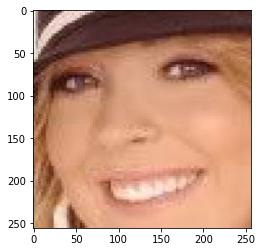

In [15]:
#plotting test image
plt.imshow(transforms.ToPILImage()(ims[1]))
plt.savefig("drive/MyDrive/original.jpg")

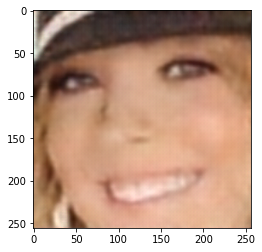

In [16]:
#running test image, not noise, through the model
test = new_ims[:10].to("cuda")
mu,var = encoder(test)
x = middlePart(mu,var)
out = decoder(x)
out = torch.reshape(out,(10,3,256,256))

plt.imshow(transforms.ToPILImage()(out[1]))
plt.savefig("drive/MyDrive/out.jpg")

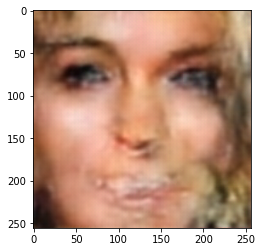

In [17]:
#Testing noise on the decoder
noise = torch.rand(batch_size,128).to("cuda")
new = decoder(noise)
new = torch.reshape(new,(batch_size,3,256,256))
plt.imshow(transforms.ToPILImage()(new[0]))

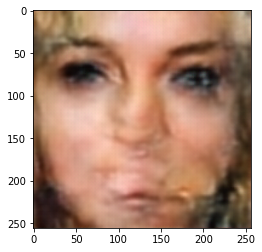

In [18]:
#normalizing the noise
thing = torch.randn(batch_size,128).to("cuda") + x
thing += 4.4091
thing /= 8.9392
out_thing = decoder(thing)
out_thing = torch.reshape(out_thing,(10,3,256,256))

plt.imshow(transforms.ToPILImage()(out_thing[0]))